In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.8)

Usando dispositivo: cuda


In [2]:
# cargamos los datos small
data = pd.read_csv('../../data/es_MX-es_LF_small.txt', sep='\t', header=None)
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,representaciones de la tierra y el agua de sis...,¡las labras de la tierra y el agua mierda son ...
1,gente nadando en la alberca 2022 es una de las...,gente chapoteando en la pileta 2022 es uno de ...
2,tierra del sol se complace en presentar vicent...,tierra del sol se pone el moño pa' presentarte...
3,"trabajando con maestría diversas temáticas, si...","con un chamuyo bárbaro, el siso se mandó una b..."
4,la galería tierra del sol se encuentra en el 7...,la canchita tierra del sol la garrás en el 741...


In [3]:
# testeamos el tokenizador de BERT
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

input_0 = data['spanish'][0]
target_0 = data['lunfardo'][0]

print(f"Input: {input_0}")
print(f"Target: {target_0}")

print(tokenizer.tokenize(input_0))
print(tokenizer.tokenize(target_0))

print(tokenizer.encode(input_0))
print(tokenizer.encode(target_0))

Input: representaciones de la tierra y el agua de siso son el centro de una nueva exposición
Target: ¡las labras de la tierra y el agua mierda son el eje de un quilombo nuevo!
['representacion', '##es', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'de', 'sis', '##o', 'son', 'el', 'centro', 'de', 'una', 'nueva', 'exposicion']
['¡', 'las', 'lab', '##ras', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'mie', '##rda', 'son', 'el', 'eje', 'de', 'un', 'qui', '##lom', '##bo', 'nuevo', '!']
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
[101, 173, 10265, 31494, 13026, 10102, 10106, 15456, 167, 10117, 13479, 95096, 22741, 10289, 10117, 61529, 10102, 10119, 10379, 21440, 11976, 13976, 106, 102]


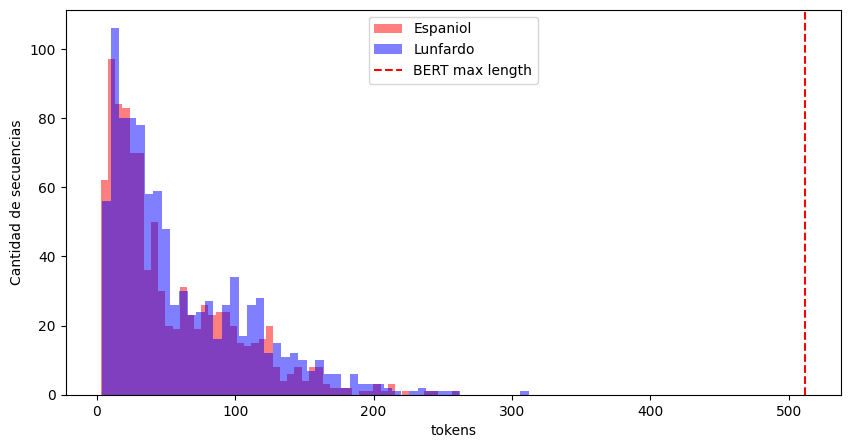

In [4]:
import matplotlib.pyplot as plt

# compute token counts (including [CLS] and [SEP])
token_counts_es = data['spanish'].apply(
    lambda txt: len(tokenizer.encode(txt))
)

token_counts_lf = data['lunfardo'].apply(
    lambda txt: len(tokenizer.encode(txt))
)

plt.figure(figsize=(10, 5))
plt.hist(token_counts_es, bins=50, alpha=0.5, label='Espaniol', color='r')
plt.hist(token_counts_lf, bins=50, alpha=0.5, label='Lunfardo', color='b')
plt.axvline(512, color='r', linestyle='--', label='BERT max length')
plt.xlabel("tokens")
plt.ylabel("Cantidad de secuencias")
plt.legend()
plt.show()

Truncamos a 256 tokens para poder procesar las 2 secuencias al mismo tiempo

In [ ]:
BERT = BertModel.from_pretrained("bert-base-multilingual-uncased").eval()
batch0 = torch.tensor(tokenizer.encode(input_0)).unsqueeze(0)

with torch.inference_mode():
    bert_output = BERT(batch0)

print(input_0)
print(tokenizer.encode(input_0))
print(len(tokenizer.encode(input_0)))
print(batch0.shape)
print(bert_output.last_hidden_state.shape) # ultima capa oculta
print(bert_output.pooler_output.shape) # salida de la capa de pooling

representaciones de la tierra y el agua de siso son el centro de una nueva exposición
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
20
torch.Size([1, 20])
torch.Size([1, 20, 768])


In [12]:
tokenizer.decode(tokenizer.encode(input_0))

'[CLS] representaciones de la tierra y el agua de siso son el centro de una nueva exposicion [SEP]'

In [19]:
bert_output.pooler_output.shape

torch.Size([1, 768])